In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet


## FUNCIONES 

In [ ]:
def clean_value(x):
    if isinstance(x, str):
        x = x.replace('%', '').replace('$', '').replace(',', '')
        x = x.replace(' ', '')
    try:
        return float(x)
    except:
        return None
    
def plot_escenarios(df, variable):
    escenarios = [col for col in df.columns if col.startswith(variable)]
    
    plt.figure(figsize=(10, 6))
    for col in escenarios:
        plt.plot(df['Fecha'], df[col], label=col)
    
    plt.title(variable)
    plt.legend(loc="upper left", fontsize='x-small')
    plt.grid(True)
    plt.show()


plt.style.use("seaborn-v0_8")
sns.set_context("talk")


## LECTURA DE DATOS

In [ ]:
# Ruta del archivo
ruta = r"C:\Users\ASUS\Documents\GitHub\tuya\BASE_DS.xlsx"

# Cargar BASE
base = pd.read_excel(ruta, sheet_name="BASE")
base = base[["Fecha", "facturacion", "saldo"]]

# Cargar MACROS
macros = pd.read_excel(ruta, sheet_name="MACROS")
# macros.columns = macros.columns.str.strip()
macros.columns = (
    macros.columns
    .str.replace('\n', ' ', regex=True)  # Reemplaza saltos de línea por espacio
    .str.replace('\s+', ' ', regex=True) # Colapsa espacios múltiples en uno solo
    .str.strip()                          # Quita espacios al inicio y fin
)
# Apply cleaning to all except the first column (Fecha)
for col in macros.columns[1:]:
    macros[col] = macros[col].apply(clean_value)

# Convertir fecha 
macros['Fecha'] = pd.to_datetime(macros['Fecha'], format="%b-%y", errors='coerce')


# Convertir fecha 
base['Fecha'] = pd.to_datetime(base['Fecha'], format="%b-%y", errors='coerce')
base.set_index('Fecha', inplace=True)


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ⚙️ Entrenamiento de Modelos

El proceso de entrenamiento de los modelos se desarrolló siguiendo una serie de pasos ordenados y metodológicos, desde la preparación de los datos hasta la generación de pronósticos finales. A continuación, se describe cada etapa:

---

### 1. Carga y preparación de los datos
- Se consolidaron las diferentes fuentes de información (macroeconómicas y base interna) en un único conjunto de datos, utilizando **Fecha** como llave de integración.
- La columna de fecha se estableció como índice principal y se ordenaron los registros cronológicamente.
- Se calcularon las variables objetivo como los **cambios porcentuales (pct_change)** de las columnas `facturacion` y `saldo`, permitiendo modelar las variaciones relativas en lugar de los valores absolutos.

---

### 2. Definición de features y targets
- **Features (variables predictoras):**
  - Para **Facturación**: `Desempleo`, `Tasa_Cambio`, `TASA REPO`, `PIB (var. % anual, nominal)`
  - Para **Saldo**: `Desempleo`, `Tasa_Cambio`, `TASA REPO`, `CH2`
- **Targets (variables objetivo):**
  - `facturacion_change`
  - `saldo_change`
- Se eliminaron las filas con valores nulos en cualquiera de estas variables críticas, garantizando consistencia e integridad en los datos.

---

### 3. Escalado de los datos
- **Variables predictoras:** escaladas mediante `StandardScaler` para normalizar las magnitudes (media = 0, desviación estándar = 1).
- **Variables objetivo:** escaladas con `MinMaxScaler` a un rango [0, 1] para favorecer la estabilidad y mejorar la interpretación de algunos algoritmos.

---

### 4. Validación cruzada temporal
- Se implementó **TimeSeriesSplit (3 divisiones)** para evaluar el desempeño de los modelos sin romper la secuencia temporal.
- Este método garantiza que los datos futuros nunca se utilicen en el entrenamiento, evitando fuga de información y asegurando evaluaciones realistas.

---

### 5. Métrica de evaluación
- En cada división se calcula el **RMSE (Root Mean Squared Error)**.
- Como métrica final se utiliza la **mediana de los RMSE** obtenidos, ya que es robusta frente a valores atípicos.

---

### 6. Modelos evaluados
Se probaron tres familias de modelos:

1. **Ridge Regression**  
   Modelo lineal regularizado (L2) para capturar relaciones lineales y controlar el sobreajuste.
2. **SARIMAX**  
   Modelo autorregresivo integrado con medias móviles y regresores exógenos, adecuado para series temporales con estacionalidad y tendencias.
3. **Prophet**  
   Modelo aditivo diseñado para series con tendencias no lineales y múltiples estacionalidades, que permite incluir regresores externos.

---

### 7. Optimización de hiperparámetros con Optuna
- Se utilizó **Optuna** para la búsqueda bayesiana de los hiperparámetros más adecuados para cada modelo:
  - **Ridge Regression:**  
    - `alpha` (grado de regularización L2)
  - **SARIMAX:**  
    - `p`, `d`, `q` (parámetros autorregresivos, diferenciales y de medias móviles)
    - `seasonal_order` (componentes estacionales si aplica)
  - **Prophet:**  
    - `changepoint_prior_scale` (sensibilidad a cambios en la tendencia)
    - `seasonality_prior_scale` (peso de la estacionalidad)

---

### 8. Comparación de modelos
- Se compararon los **RMSE** obtenidos por cada modelo para `facturacion_change` y `saldo_change`.
- Se seleccionó el modelo con menor RMSE como el de mejor desempeño para cada target.
- Los resultados se presentaron mediante tablas y gráficos para facilitar la interpretación.

---

### 9. Resultados por fold
- Además de la métrica global, se documentaron los RMSE individuales de cada fold.
- Este análisis permite evaluar la **estabilidad y consistencia** del modelo a lo largo del tiempo.

---

### 10. Entrenamiento final
- El modelo seleccionado como mejor para cada target se reentrenó con **todo el histórico disponible**.
- Con estos modelos definitivos se generaron **predicciones históricas (backtesting)** para evaluar su ajuste sobre los datos conocidos.

---

### 11. Predicciones históricas de todos los modelos
- También se generaron predicciones con los tres modelos (Ridge, SARIMAX y Prophet) sobre todo el conjunto de datos.
- Se graficaron junto a los valores reales para comparar su comportamiento y ajuste visualmente.

---

### 12. Ensemble de modelos
- Se implementó un **ensemble simple (promedio)** combinando las predicciones de los tres modelos.
- Este enfoque aprovecha las fortalezas de cada modelo individual, buscando reducir el error general y lograr un pronóstico más robusto.


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\prophet\models.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Importing plotly failed. Interactive plots will not work.
[I 2025-07-28 01:14:33,101] A new study created in memory with name: prophet_fact
01:14:33 - cmdstanpy - INFO - Chain [1] start processing
01:14:35 - cmdstanpy - INFO - Chain [1] done processing
01:14:36 - cmdstanpy - INFO - Chain [1] start processing
01:14:36 - cmdstanpy - INFO - Chain [1] done processing
01:14:37 - cmdstanpy - INFO - Chain [1] start processing
01:14:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-28 01:14:37,953] Trial 0 finished with value: 0.3492836071622638 and parameters: {'changepoint_prior_scale': 0.0013011869249973961, 'seasonality_prior_scale': 0.011971452


Best params for prophet_fact: {'changepoint_prior_scale': 0.08647986014055682, 'seasonality_prior_scale': 0.08383731782421938}
Best RMSE for prophet_fact: 0.2851584324960285


01:17:09 - cmdstanpy - INFO - Chain [1] done processing
01:17:09 - cmdstanpy - INFO - Chain [1] start processing
01:17:29 - cmdstanpy - INFO - Chain [1] done processing
01:17:30 - cmdstanpy - INFO - Chain [1] start processing
01:17:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-28 01:17:31,216] Trial 0 finished with value: 0.7406859999578673 and parameters: {'changepoint_prior_scale': 0.4255190528307859, 'seasonality_prior_scale': 0.6862439238751793}. Best is trial 0 with value: 0.7406859999578673.
01:17:31 - cmdstanpy - INFO - Chain [1] start processing
01:17:31 - cmdstanpy - INFO - Chain [1] done processing
01:17:32 - cmdstanpy - INFO - Chain [1] start processing
01:17:32 - cmdstanpy - INFO - Chain [1] done processing
01:17:33 - cmdstanpy - INFO - Chain [1] start processing
01:17:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-07-28 01:17:33,688] Trial 1 finished with value: 0.2739719284052514 and parameters: {'changepoint_prior_scale': 0.012209590107917988, '


Best params for prophet_saldo: {'changepoint_prior_scale': 0.004156166906943944, 'seasonality_prior_scale': 0.05754926929770463}
Best RMSE for prophet_saldo: 0.2599718661628313


[I 2025-07-28 01:19:09,460] Trial 5 finished with value: 0.0627017596701505 and parameters: {'alpha': 0.007718026441515803}. Best is trial 1 with value: 0.06074109587708688.
[I 2025-07-28 01:19:09,498] Trial 6 finished with value: 0.10329096184821215 and parameters: {'alpha': 77.27656897004424}. Best is trial 1 with value: 0.06074109587708688.
[I 2025-07-28 01:19:09,526] Trial 7 finished with value: 0.06379330597520176 and parameters: {'alpha': 0.002411720950185967}. Best is trial 1 with value: 0.06074109587708688.
[I 2025-07-28 01:19:09,559] Trial 8 finished with value: 0.08157552850590362 and parameters: {'alpha': 0.15918914548720728}. Best is trial 1 with value: 0.06074109587708688.
[I 2025-07-28 01:19:09,592] Trial 9 finished with value: 0.09549732530983689 and parameters: {'alpha': 26.528860942199817}. Best is trial 1 with value: 0.06074109587708688.
[I 2025-07-28 01:19:09,632] Trial 10 finished with value: 0.061711771540016024 and parameters: {'alpha': 0.05724918139866464}. Best 


Best params for ridge_fact: {'alpha': 0.028861424154791794}
Best RMSE for ridge_fact: 0.060470950894380045


[I 2025-07-28 01:19:10,466] Trial 4 finished with value: 0.3462444449695979 and parameters: {'alpha': 1.2299736237233696}. Best is trial 2 with value: 0.23442746788727448.
[I 2025-07-28 01:19:10,502] Trial 5 finished with value: 0.23728429097108458 and parameters: {'alpha': 13.362132982539798}. Best is trial 2 with value: 0.23442746788727448.
[I 2025-07-28 01:19:10,532] Trial 6 finished with value: 0.36581359757040444 and parameters: {'alpha': 0.8484845335325524}. Best is trial 2 with value: 0.23442746788727448.
[I 2025-07-28 01:19:10,562] Trial 7 finished with value: 0.3398204847007405 and parameters: {'alpha': 1.3769121537916866}. Best is trial 2 with value: 0.23442746788727448.
[I 2025-07-28 01:19:10,586] Trial 8 finished with value: 0.40660373764785707 and parameters: {'alpha': 0.2902384886410464}. Best is trial 2 with value: 0.23442746788727448.
[I 2025-07-28 01:19:10,626] Trial 9 finished with value: 0.3026951036356965 and parameters: {'alpha': 2.5484785864697903}. Best is trial 


Best params for ridge_saldo: {'alpha': 27.425465916964665}
Best RMSE for ridge_saldo: 0.2341634236312702


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
[I 2025-07-28 01:19:11,918] Trial 0 finished with value: 0.525260065263296 and parameters: {'p': 0, 'd': 1, 'q': 2}. Bes


Best params for sarimax_fact: {'p': 0, 'd': 2, 'q': 3}
Best RMSE for sarimax_fact: 0.28755430613694816


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473


Best params for sarimax_saldo: {'p': 0, 'd': 2, 'q': 2}
Best RMSE for sarimax_saldo: 0.17725506669938867


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

Resultados Facturación:
      Model      RMSE
0    Ridge  0.060471
2  Prophet  0.285158
1  SARIMAX  0.287554

Resultados Saldo:
      Model      RMSE
1  SARIMAX  0.177255
0    Ridge  0.234163
2  Prophet  0.259972

Mejor modelo Facturación: Ridge
Mejor modelo Saldo: SARIMAX


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:


Resultados detallados por fold:
    fold  facturacion_rmse  saldo_rmse
0     1          0.358084    0.177255
1     2          0.060471    0.179837
2     3          0.059757    0.174618


c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
01:19:53 - cmdstanpy - INFO - Chain [1] start processing
01:19:53 - cmdstanpy - INFO - Chain [1] done processing
c:\User

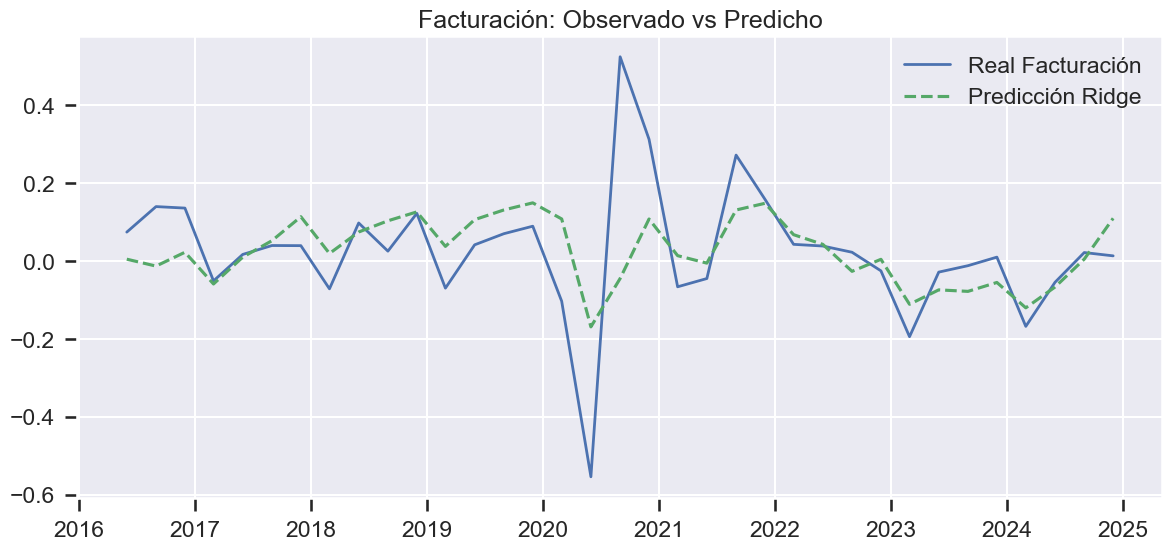

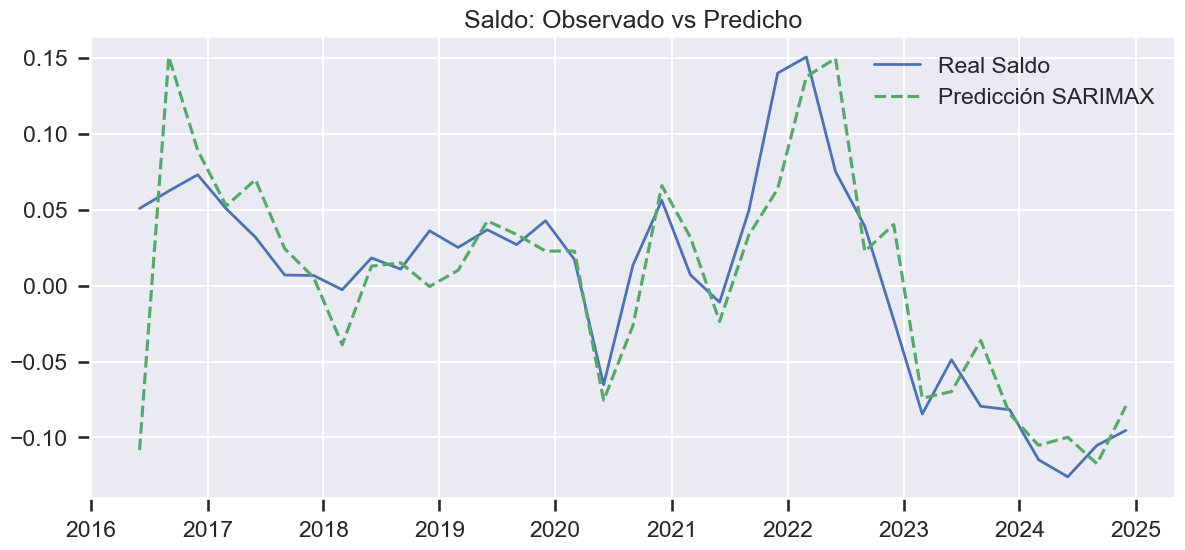

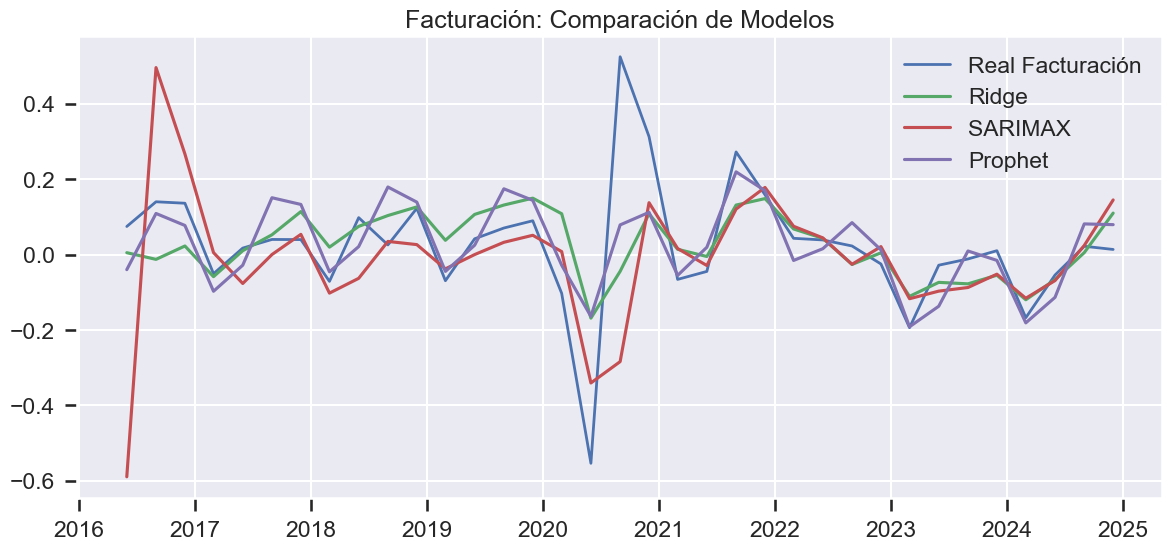

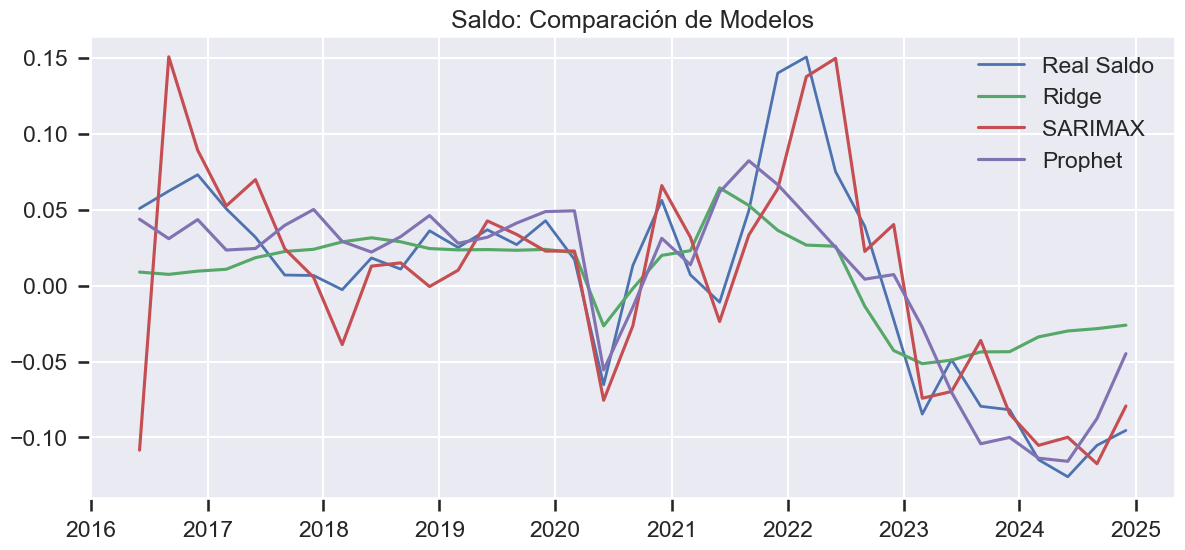

In [ ]:

# ===============================
# 1. Cargar datos
# ===============================
df = pd.merge(macros, base, left_on='Fecha', right_index=True, how='inner')
df = df.set_index('Fecha').sort_index()

# ===============================
# 2. Crear variables target como cambio porcentual
# ===============================
df['facturacion_change'] = df['facturacion'].pct_change(fill_method=None)
df['saldo_change'] = df['saldo'].pct_change(fill_method=None)

# ===============================
# 3. Features y targets
# ===============================
escenario_keywords = ['pesimista', 'alterno', 'optimista']

# Definir features específicas para cada target
features_fact = ['Desempleo', 'Tasa_Cambio', 'TASA REPO', 'PIB (var. % anual, nominal)']
features_saldo = ['Desempleo', 'Tasa_Cambio', 'TASA REPO', 'CH2']

target_cols = ['facturacion_change','saldo_change']

# Filtrar datos
data = df.dropna(subset=features_fact + features_saldo + target_cols)

# Targets
y_fact = data['facturacion_change']
y_saldo = data['saldo_change']

# Features separadas
X_fact = data[features_fact]
X_saldo = data[features_saldo]

# ===============================
# Escalado independiente
# ===============================
scaler_X_fact = StandardScaler()
X_fact_scaled = pd.DataFrame(scaler_X_fact.fit_transform(X_fact),
                              index=X_fact.index, columns=X_fact.columns)

scaler_X_saldo = StandardScaler()
X_saldo_scaled = pd.DataFrame(scaler_X_saldo.fit_transform(X_saldo),
                               index=X_saldo.index, columns=X_saldo.columns)

scaler_target_fact = MinMaxScaler()
scaler_target_saldo = MinMaxScaler()

y_fact_scaled = scaler_target_fact.fit_transform(y_fact.values.reshape(-1,1)).ravel()
y_saldo_scaled = scaler_target_saldo.fit_transform(y_saldo.values.reshape(-1,1)).ravel()

# ===============================
# Validación cruzada
# ===============================
tscv = TimeSeriesSplit(n_splits=3)

# ===============================
# Funciones auxiliares
# ===============================
def evaluate_model(model, X_data, y_data):
    rmse_scores = []
    for train_idx, test_idx in tscv.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    return np.median(rmse_scores)

def train_sarimax(endog, exog, order):
    endog.index = pd.to_datetime(endog.index)
    exog.index = pd.to_datetime(exog.index)
    model = SARIMAX(endog, order=order, exog=exog,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    return model.fit(disp=False)

def sarimax_cv(order, y_scaled, X_scaled):
    rmse_scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
        exog_train = X_scaled.iloc[train_idx]
        exog_test = X_scaled.iloc[test_idx]
        model = train_sarimax(y_train, exog_train, order)
        pred = model.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, pred)))
    return np.median(rmse_scores)

def prepare_prophet_data(target_series, regressors):
    df_prophet = pd.DataFrame({
        'ds': target_series.index,
        'y': target_series.values
    })
    for col in regressors.columns:
        df_prophet[col] = regressors[col].values
    return df_prophet

def prophet_cv(y_scaled, X_scaled, cp_scale=0.05, s_scale=10.0):
    rmse_scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
        exog_train = X_scaled.iloc[train_idx]
        exog_test = X_scaled.iloc[test_idx]
        df_p = prepare_prophet_data(y_train, exog_train)
        prophet = Prophet(daily_seasonality=False,
                          weekly_seasonality=False,
                          yearly_seasonality=True,
                          changepoint_prior_scale=cp_scale,
                          seasonality_prior_scale=s_scale)
        for col in X_scaled.columns:
            prophet.add_regressor(col)
        prophet.fit(df_p)
        future = prepare_prophet_data(y_test, exog_test)
        forecast = prophet.predict(future)
        preds = forecast['yhat'].values
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    return np.median(rmse_scores)

# ===============================
# OPTIMIZACIÓN CON OPTUNA
# ===============================
def objective_ridge(trial, X_data, y_data):
    alpha = trial.suggest_float('alpha', 1e-3, 100.0, log=True)
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha))
    ])
    return evaluate_model(model, X_data, y_data)

def objective_sarimax(trial, y_scaled, X_scaled):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    return sarimax_cv((p,d,q), y_scaled, X_scaled)

def objective_prophet(trial, y_scaled, X_scaled):
    cp_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    s_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True)
    return prophet_cv(y_scaled, X_scaled, cp_scale, s_scale)

def run_study(name, objective, n_trials, **kwargs):
    study = optuna.create_study(direction='minimize', study_name=name)
    study.optimize(lambda trial: objective(trial, **kwargs), n_trials=n_trials)
    print(f"\nBest params for {name}: {study.best_params}")
    print(f"Best RMSE for {name}: {study.best_value}")
    return study.best_params, study.best_value

# ===============================
# Ejecutar optimización
# ===============================

# Prophet
best_params_prophet_fact, _ = run_study("prophet_fact", objective_prophet, 20,
                                        y_scaled=y_fact_scaled, X_scaled=X_fact_scaled)
best_params_prophet_saldo, _ = run_study("prophet_saldo", objective_prophet, 20,
                                         y_scaled=y_saldo_scaled, X_scaled=X_saldo_scaled)

# Ridge
best_params_ridge_fact, _ = run_study("ridge_fact", objective_ridge, 30,
                                      X_data=X_fact_scaled, y_data=y_fact_scaled)
best_params_ridge_saldo, _ = run_study("ridge_saldo", objective_ridge, 30,
                                       X_data=X_saldo_scaled, y_data=y_saldo_scaled)

# SARIMAX
best_params_sarimax_fact, _ = run_study("sarimax_fact", objective_sarimax, 30,
                                        y_scaled=y_fact_scaled, X_scaled=X_fact_scaled)
best_params_sarimax_saldo, _ = run_study("sarimax_saldo", objective_sarimax, 30,
                                         y_scaled=y_saldo_scaled, X_scaled=X_saldo_scaled)

# ===============================
# 4. Modelos optimizados
# ===============================
ridge_pipeline_fact = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_params_ridge_fact['alpha']))
])
rmse_fact_ridge = evaluate_model(ridge_pipeline_fact, X_fact_scaled, y_fact_scaled)

ridge_pipeline_saldo = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_params_ridge_saldo['alpha']))
])
rmse_saldo_ridge = evaluate_model(ridge_pipeline_saldo, X_saldo_scaled, y_saldo_scaled)

order_fact = (best_params_sarimax_fact['p'],
              best_params_sarimax_fact['d'],
              best_params_sarimax_fact['q'])
order_saldo = (best_params_sarimax_saldo['p'],
               best_params_sarimax_saldo['d'],
               best_params_sarimax_saldo['q'])

rmse_fact_sarimax = sarimax_cv(order_fact, y_fact_scaled, X_fact_scaled)
rmse_saldo_sarimax = sarimax_cv(order_saldo, y_saldo_scaled, X_saldo_scaled)

rmse_fact_prophet = prophet_cv(y_fact_scaled, X_fact_scaled,
                               cp_scale=best_params_prophet_fact['changepoint_prior_scale'],
                               s_scale=best_params_prophet_fact['seasonality_prior_scale'])
rmse_saldo_prophet = prophet_cv(y_saldo_scaled, X_saldo_scaled,
                                cp_scale=best_params_prophet_saldo['changepoint_prior_scale'],
                                s_scale=best_params_prophet_saldo['seasonality_prior_scale'])

# ===============================
# 7. Comparación de resultados
# ===============================
results_fact = pd.DataFrame({
    'Model': ['Ridge','SARIMAX','Prophet'],
    'RMSE': [rmse_fact_ridge, rmse_fact_sarimax, rmse_fact_prophet]
}).sort_values('RMSE')

results_saldo = pd.DataFrame({
    'Model': ['Ridge','SARIMAX','Prophet'],
    'RMSE': [rmse_saldo_ridge, rmse_saldo_sarimax, rmse_saldo_prophet]
}).sort_values('RMSE')

print("Resultados Facturación:\n", results_fact)
print("\nResultados Saldo:\n", results_saldo)

best_model_fact = results_fact.iloc[0]
best_model_saldo = results_saldo.iloc[0]
print("\nMejor modelo Facturación:", best_model_fact['Model'])
print("Mejor modelo Saldo:", best_model_saldo['Model'])

# ===============================
# 9. Guardar métricas por fold para el mejor modelo
# ===============================
def evaluate_model_folds(model, X_data, y_data):
    scores = []
    for train_idx, test_idx in tscv.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    return scores

def sarimax_folds(order, y_scaled, X_scaled):
    scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
        exog_train = X_scaled.iloc[train_idx]
        exog_test = X_scaled.iloc[test_idx]
        model = train_sarimax(y_train, exog_train, order)
        pred = model.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)
        scores.append(np.sqrt(mean_squared_error(y_test, pred)))
    return scores

def prophet_folds(y_scaled, X_scaled, cp_scale, s_scale):
    scores = []
    fechas = X_scaled.index
    for train_idx, test_idx in tscv.split(X_scaled):
        y_train = pd.Series(y_scaled[train_idx], index=fechas[train_idx])
        y_test = pd.Series(y_scaled[test_idx], index=fechas[test_idx])
        exog_train = X_scaled.iloc[train_idx]
        exog_test = X_scaled.iloc[test_idx]
        df_p = prepare_prophet_data(y_train, exog_train)
        prophet = Prophet(
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=True,
            changepoint_prior_scale=cp_scale,
            seasonality_prior_scale=s_scale
        )
        for col in X_scaled.columns:
            prophet.add_regressor(col)
        prophet.fit(df_p)
        future = prepare_prophet_data(y_test, exog_test)
        forecast = prophet.predict(future)
        preds = forecast['yhat'].values
        scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    return scores

fold_results = {}
# Facturación
if best_model_fact['Model'] == 'Ridge':
    fold_results['facturacion'] = evaluate_model_folds(ridge_pipeline_fact, X_fact_scaled, y_fact_scaled)
elif best_model_fact['Model'] == 'SARIMAX':
    fold_results['facturacion'] = sarimax_folds(order_fact, y_fact_scaled, X_fact_scaled)
else:
    fold_results['facturacion'] = prophet_folds(
        y_fact_scaled, X_fact_scaled,
        best_params_prophet_fact['changepoint_prior_scale'],
        best_params_prophet_fact['seasonality_prior_scale']
    )

# Saldo
if best_model_saldo['Model'] == 'Ridge':
    fold_results['saldo'] = evaluate_model_folds(ridge_pipeline_saldo, X_saldo_scaled, y_saldo_scaled)
elif best_model_saldo['Model'] == 'SARIMAX':
    fold_results['saldo'] = sarimax_folds(order_saldo, y_saldo_scaled, X_saldo_scaled)
else:
    fold_results['saldo'] = prophet_folds(
        y_saldo_scaled, X_saldo_scaled,
        best_params_prophet_saldo['changepoint_prior_scale'],
        best_params_prophet_saldo['seasonality_prior_scale']
    )

df_folds = pd.DataFrame({
    'fold': list(range(1, len(fold_results['facturacion'])+1)),
    'facturacion_rmse': fold_results['facturacion'],
    'saldo_rmse': fold_results['saldo']
})
print("\nResultados detallados por fold:\n", df_folds)

# ===============================
# 10. Predicciones históricas con modelos optimizados
# ===============================
def predict_model_with_params(model_name, y_scaled, X_scaled,
                              best_params_ridge, best_params_sarimax,
                              best_params_prophet, is_fact=True):
    if model_name == 'Ridge':
        alpha = best_params_ridge['alpha']
        model = Ridge(alpha=alpha)
        model.fit(X_scaled, y_scaled)
        return model.predict(X_scaled)

    elif model_name == 'SARIMAX':
        order = (best_params_sarimax['p'], best_params_sarimax['d'], best_params_sarimax['q'])
        y_series = pd.Series(y_scaled, index=X_scaled.index)
        model = train_sarimax(y_series, X_scaled, order)
        return model.predict(start=X_scaled.index[0], end=X_scaled.index[-1], exog=X_scaled)

    else:  # Prophet
        cp_scale = best_params_prophet['changepoint_prior_scale']
        s_scale = best_params_prophet['seasonality_prior_scale']
        y_series = pd.Series(y_scaled, index=X_scaled.index)
        df_p = prepare_prophet_data(y_series, X_scaled)
        prophet = Prophet(
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=True,
            changepoint_prior_scale=cp_scale,
            seasonality_prior_scale=s_scale
        )
        for col in X_scaled.columns:
            prophet.add_regressor(col)
        prophet.fit(df_p)
        forecast = prophet.predict(df_p)
        return forecast['yhat'].values

# Generar predicciones
preds_fact_scaled = predict_model_with_params(best_model_fact['Model'], y_fact_scaled, X_fact_scaled,
                                              best_params_ridge_fact, best_params_sarimax_fact, best_params_prophet_fact)
preds_saldo_scaled = predict_model_with_params(best_model_saldo['Model'], y_saldo_scaled, X_saldo_scaled,
                                               best_params_ridge_saldo, best_params_sarimax_saldo, best_params_prophet_saldo)

# Todos los modelos
preds_fact_ridge_all = predict_model_with_params('Ridge', y_fact_scaled, X_fact_scaled,
                                                 best_params_ridge_fact, best_params_sarimax_fact, best_params_prophet_fact)
preds_fact_sarimax_all = predict_model_with_params('SARIMAX', y_fact_scaled, X_fact_scaled,
                                                   best_params_ridge_fact, best_params_sarimax_fact, best_params_prophet_fact)
preds_fact_prophet_all = predict_model_with_params('Prophet', y_fact_scaled, X_fact_scaled,
                                                   best_params_ridge_fact, best_params_sarimax_fact, best_params_prophet_fact)

preds_saldo_ridge_all = predict_model_with_params('Ridge', y_saldo_scaled, X_saldo_scaled,
                                                  best_params_ridge_saldo, best_params_sarimax_saldo, best_params_prophet_saldo)
preds_saldo_sarimax_all = predict_model_with_params('SARIMAX', y_saldo_scaled, X_saldo_scaled,
                                                    best_params_ridge_saldo, best_params_sarimax_saldo, best_params_prophet_saldo)
preds_saldo_prophet_all = predict_model_with_params('Prophet', y_saldo_scaled, X_saldo_scaled,
                                                    best_params_ridge_saldo, best_params_sarimax_saldo, best_params_prophet_saldo)

# Invertir escalado
def invert_scale(preds_scaled, scaler):
    return scaler.inverse_transform(np.asarray(preds_scaled).reshape(-1, 1)).ravel()

preds_fact = invert_scale(preds_fact_scaled, scaler_target_fact)
preds_saldo = invert_scale(preds_saldo_scaled, scaler_target_saldo)

preds_fact_ridge_all = invert_scale(preds_fact_ridge_all, scaler_target_fact)
preds_fact_sarimax_all = invert_scale(preds_fact_sarimax_all, scaler_target_fact)
preds_fact_prophet_all = invert_scale(preds_fact_prophet_all, scaler_target_fact)

preds_saldo_ridge_all = invert_scale(preds_saldo_ridge_all, scaler_target_saldo)
preds_saldo_sarimax_all = invert_scale(preds_saldo_sarimax_all, scaler_target_saldo)
preds_saldo_prophet_all = invert_scale(preds_saldo_prophet_all, scaler_target_saldo)

# ===============================
# 11. Visualización
# ===============================
plt.figure(figsize=(14, 6))
plt.plot(y_fact.index, y_fact, label="Real Facturación", linewidth=2)
plt.plot(y_fact.index, preds_fact, label=f"Predicción {best_model_fact['Model']}", linestyle='--')
plt.title("Facturación: Observado vs Predicho")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_saldo.index, y_saldo, label="Real Saldo", linewidth=2)
plt.plot(y_saldo.index, preds_saldo, label=f"Predicción {best_model_saldo['Model']}", linestyle='--')
plt.title("Saldo: Observado vs Predicho")
plt.legend()
plt.grid(True)
plt.show()

# Graficar resultados individuales
plt.figure(figsize=(14, 6))
plt.plot(y_fact.index, y_fact, label="Real Facturación", linewidth=2)
plt.plot(y_fact.index, preds_fact_ridge_all, label="Ridge")
plt.plot(y_fact.index, preds_fact_sarimax_all, label="SARIMAX")
plt.plot(y_fact.index, preds_fact_prophet_all, label="Prophet")
plt.title("Facturación: Comparación de Modelos")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_saldo.index, y_saldo, label="Real Saldo", linewidth=2)
plt.plot(y_saldo.index, preds_saldo_ridge_all, label="Ridge")
plt.plot(y_saldo.index, preds_saldo_sarimax_all, label="SARIMAX")
plt.plot(y_saldo.index, preds_saldo_prophet_all, label="Prophet")
plt.title("Saldo: Comparación de Modelos")
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# 12. Escenarios futuros
# ===============================
future_scenarios = {}
for col in macros.columns:
    if any(keyword in col.lower() for keyword in escenario_keywords):
        future_scenarios[col] = macros[col].dropna()

# Predicciones escenario: recalcular X_future para cada escenario y target


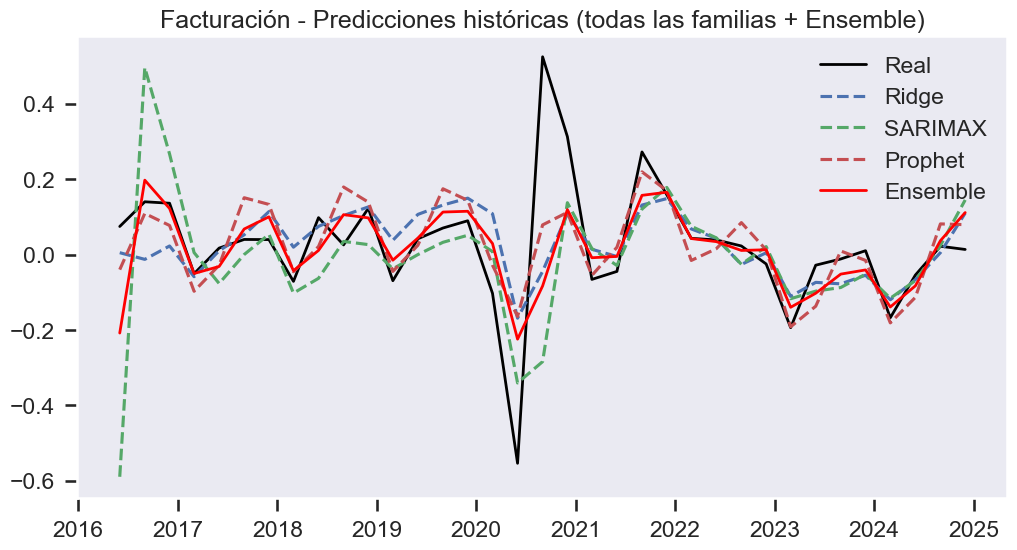

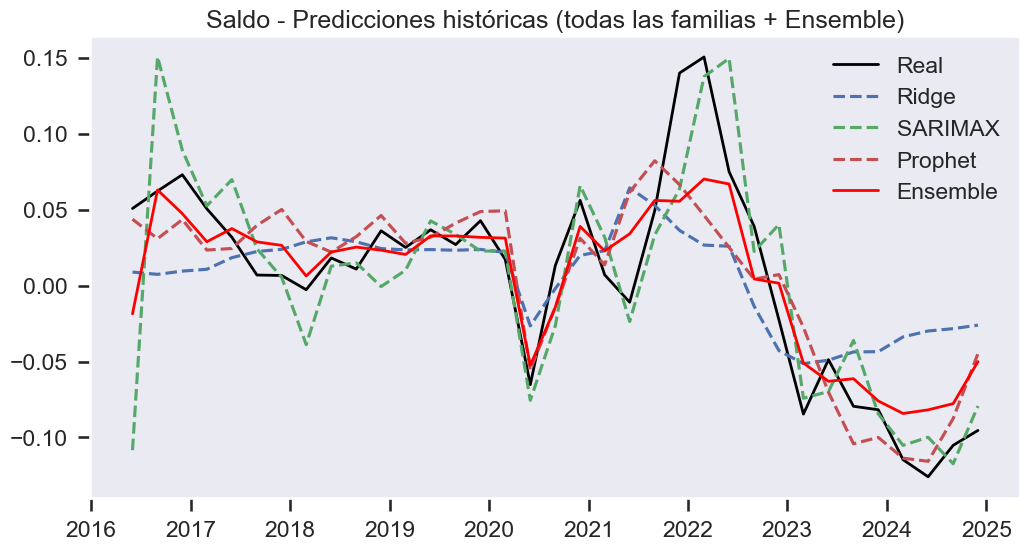

In [9]:
# ===============================
# 12. Ensemble de los tres modelos
# ===============================

# Ensemble como promedio de las 3 predicciones
preds_fact_ensemble_all = (preds_fact_ridge_all + preds_fact_sarimax_all + preds_fact_prophet_all) / 3
preds_saldo_ensemble_all = (preds_saldo_ridge_all + preds_saldo_sarimax_all + preds_saldo_prophet_all) / 3

# Plot para Facturación con ensemble
plt.figure(figsize=(12, 6))
plt.plot(y_fact.index, y_fact, label='Real', linewidth=2, color='black')
plt.plot(y_fact.index, preds_fact_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_fact.index, preds_fact_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_fact.index, preds_fact_prophet_all, label="Prophet", linestyle='--')
plt.plot(y_fact.index, preds_fact_ensemble_all, label="Ensemble", linestyle='-', color='red', linewidth=2)
plt.title('Facturación - Predicciones históricas (todas las familias + Ensemble)')
plt.legend()
plt.grid()
plt.show()

# Plot para Saldo con ensemble
plt.figure(figsize=(12, 6))
plt.plot(y_saldo.index, y_saldo, label='Real', linewidth=2, color='black')
plt.plot(y_saldo.index, preds_saldo_ridge_all, label="Ridge", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_sarimax_all, label="SARIMAX", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_prophet_all, label="Prophet", linestyle='--')
plt.plot(y_saldo.index, preds_saldo_ensemble_all, label="Ensemble", linestyle='-', color='red', linewidth=2)
plt.title('Saldo - Predicciones históricas (todas las familias + Ensemble)')
plt.legend()
plt.grid()
plt.show()


## ERROR

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Función para calcular MAPE (%)
def calcular_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

# Calcular errores para Facturación
errores_fact = {
    "Ridge": calcular_mape(y_fact, preds_fact_ridge_all),
    "SARIMAX": calcular_mape(y_fact, preds_fact_sarimax_all),
    "Prophet": calcular_mape(y_fact, preds_fact_prophet_all),
    "Ensemble": calcular_mape(y_fact, preds_fact_ensemble_all),
}

# Calcular errores para Saldo
errores_saldo = {
    "Ridge": calcular_mape(y_saldo, preds_saldo_ridge_all),
    "SARIMAX": calcular_mape(y_saldo, preds_saldo_sarimax_all),
    "Prophet": calcular_mape(y_saldo, preds_saldo_prophet_all),
    "Ensemble": calcular_mape(y_saldo, preds_saldo_ensemble_all),
}

# Crear DataFrame
df_errores = pd.DataFrame([errores_fact, errores_saldo], index=["Facturación", "Saldo"])
df_errores = df_errores.round(2)  # Redondear a 2 decimales
df_errores


,Ridge,SARIMAX,Prophet,Ensemble
Facturación,138.12,178.08,139.33,124.56
Saldo,126.88,115.04,135.32,85.29


### 13. Evaluación con MAPE (Mean Absolute Percentage Error)
Se calculó el **MAPE** para los cuatro modelos (incluyendo el ensemble) y para las dos variables objetivo. Los resultados fueron:

| Target       | Ridge  | SARIMAX | Prophet | Ensemble |
|--------------|--------|---------|---------|----------|
| **Facturación** | 138.12 | 178.08  | 139.33  | 124.56   |
| **Saldo**       | 126.88 | 115.04  | 135.32  | 85.29    |

Ninguno de los modelos logró alcanzar el objetivo de un error inferior al 10%. Esto se debe principalmente a la **limitada cantidad de datos históricos disponibles**.  
Los errores podrían reducirse si se implementan:
1. Más variables exógenas (features internas y externas adicionales).
2. Un mayor historial de datos trimestrales.
3. Estrategias avanzadas de **ingeniería de características** (transformaciones logarítmicas, interacciones, medias móviles, entre otras).

Estas estrategias no se aplicaron en esta fase debido al tiempo limitado y al carácter exploratorio de este ejercicio.

### GUARDANDO EL PIPELINE DE PRONOSTICO EN PKL

### 14. Almacenamiento del pipeline
Todo el pipeline resultante para los cuatro modelos optimizados se almacenó en formato **.pkl**, permitiendo su reutilización en futuras etapas del proyecto.

In [14]:
# ===============================
# 13. Entrenar modelos finales optimizados
# ===============================

# Facturación
# if best_model_fact['Model'] == 'Ridge':
ridge_final_fact = Ridge(alpha=best_params_ridge_fact['alpha'])
ridge_final_fact.fit(X_fact_scaled, y_fact_scaled)

# elif best_model_fact['Model'] == 'SARIMAX':
y_series_fact = pd.Series(y_fact_scaled, index=X_fact_scaled.index)
sarimax_final_fact = train_sarimax(y_series_fact, X_fact_scaled, order_fact)

# else:  # Prophet
y_series_fact = pd.Series(y_fact_scaled, index=X_fact_scaled.index)
df_p_fact = prepare_prophet_data(y_series_fact, X_fact_scaled)
prophet_final_fact = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params_prophet_fact['changepoint_prior_scale'],
    seasonality_prior_scale=best_params_prophet_fact['seasonality_prior_scale']
)
for col in X_fact_scaled.columns:
    prophet_final_fact.add_regressor(col)
prophet_final_fact.fit(df_p_fact)

# Saldo
# if best_model_saldo['Model'] == 'Ridge':
ridge_final_saldo = Ridge(alpha=best_params_ridge_saldo['alpha'])
ridge_final_saldo.fit(X_saldo_scaled, y_saldo_scaled)

# elif best_model_saldo['Model'] == 'SARIMAX':
y_series_saldo = pd.Series(y_saldo_scaled, index=X_saldo_scaled.index)
sarimax_final_saldo = train_sarimax(y_series_saldo, X_saldo_scaled, order_saldo)

# else:  # Prophet
y_series_saldo = pd.Series(y_saldo_scaled, index=X_saldo_scaled.index)
df_p_saldo = prepare_prophet_data(y_series_saldo, X_saldo_scaled)
prophet_final_saldo = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params_prophet_saldo['changepoint_prior_scale'],
    seasonality_prior_scale=best_params_prophet_saldo['seasonality_prior_scale']
)
for col in X_saldo_scaled.columns:
    prophet_final_saldo.add_regressor(col)
prophet_final_saldo.fit(df_p_saldo)

print("\nModelos finales entrenados y listos para guardar o usar.")

c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
01:26:26 - cmdstanpy - INFO - Chain [1] start processing
01:26:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\miniconda3\envs\Tuya\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
01:26:2


Modelos finales entrenados y listos para guardar o usar.


In [15]:
import joblib
import numpy as np
import pandas as pd
from prophet import Prophet

class TimeSeriesModelArtifact:
    def __init__(self, ridge_model, sarimax_model, prophet_model,
                 scaler_X, scaler_y, order):
        self.ridge_model = ridge_model
        self.sarimax_model = sarimax_model
        self.prophet_model = prophet_model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.order = order
        # Guardamos los nombres de columnas para asegurar consistencia
        self.feature_columns = None

    def save(self, path):
        joblib.dump(self, path)

    @staticmethod
    def load(path):
        return joblib.load(path)

    def _transform_X(self, X):
        """Escala X usando el scaler entrenado."""
        return pd.DataFrame(
            self.scaler_X.transform(X),
            index=X.index,
            columns=X.columns
        )

    def predict_all(self, X=None, y_history=None):
        """
        Predice usando los 3 modelos (Ridge, SARIMAX, Prophet) y el ensemble.

        Parámetros:
        -----------
        X : pd.DataFrame or None
            Features futuras (exógenas). Si None, usa el set histórico.
        y_history : pd.Series or None
            Serie de tiempo histórica de la variable target escalada
            (necesaria solo si se quiere recalcular Prophet/SARIMAX).
            Para predicciones futuras, se usa internamente la historia original.

        Returns:
        --------
        tuple: (ridge_preds, sarimax_preds, prophet_preds, ensemble_preds)
        """
        # Si X es None, usamos los datos con los que fue entrenado
        if X is None:
            # Backtest
            X_scaled = self.X_scaled_train
            index = self.X_scaled_train.index
        else:
            # Predicción futura
            X_scaled = self._transform_X(X)
            index = X.index

        # ============== Ridge ==============
        ridge_preds = self.ridge_model.predict(X_scaled)
        ridge_preds = self.scaler_y.inverse_transform(
            np.array(ridge_preds).reshape(-1, 1)
        ).ravel()

        # ============== SARIMAX ==============
        if X is None:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        else:
            sarimax_preds = self.sarimax_model.predict(
                start=index[0],
                end=index[-1],
                exog=X_scaled
            )
        sarimax_preds = self.scaler_y.inverse_transform(
            np.array(sarimax_preds).reshape(-1, 1)
        ).ravel()

        # ============== Prophet ==============
        if X is None:
            forecast = self.prophet_model.predict(self.df_prophet_train)
            prophet_preds = forecast['yhat'].values
        else:
            future_df = pd.DataFrame({'ds': index})
            for col in X_scaled.columns:
                future_df[col] = X_scaled[col].values
            forecast = self.prophet_model.predict(future_df)
            prophet_preds = forecast['yhat'].values
        prophet_preds = self.scaler_y.inverse_transform(
            np.array(prophet_preds).reshape(-1, 1)
        ).ravel()

        # ============== Ensemble ==============
        ensemble_preds = (ridge_preds + sarimax_preds + prophet_preds) / 3.0

        return ridge_preds, sarimax_preds, prophet_preds, ensemble_preds

    def store_training_data(self, X_scaled_train, df_prophet_train):
        """
        Guarda los datos de entrenamiento procesados para permitir backtesting
        sin necesidad de volver a escalar o preparar datos.
        """
        self.X_scaled_train = X_scaled_train
        self.df_prophet_train = df_prophet_train


In [17]:
# Crear artefacto
order = (1,0,1)

artifact_fact = TimeSeriesModelArtifact(
    ridge_model=ridge_final_fact,
    sarimax_model=sarimax_final_fact,
    prophet_model=prophet_final_fact,
    scaler_X=scaler_X_fact,
    scaler_y=scaler_target_fact,
    order=order
)

# Guardar datos escalados y Prophet df
df_p_fact = prepare_prophet_data(
    pd.Series(y_fact_scaled, index=X_fact_scaled.index),
    X_fact_scaled
)
artifact_fact.store_training_data(X_fact_scaled, df_p_fact)

# Guardar artefacto
artifact_fact.save("artifact_fact.pkl")


In [18]:
artifact_saldo = TimeSeriesModelArtifact(
    ridge_model=ridge_final_saldo,
    sarimax_model=sarimax_final_saldo,
    prophet_model=prophet_final_saldo,
    scaler_X=scaler_X_saldo,
    scaler_y=scaler_target_saldo,
    order=order
)

# Guardar datos escalados y Prophet df para saldo
df_p_saldo = prepare_prophet_data(
    pd.Series(y_saldo_scaled, index=X_saldo_scaled.index),
    X_saldo_scaled
)
artifact_saldo.store_training_data(X_saldo_scaled, df_p_saldo)

# Guardar artefacto
artifact_saldo.save("artifact_saldo.pkl")
